<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = True
CLAHE = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [6]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

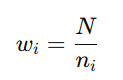

In [7]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [8]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [9]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [10]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [11]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [12]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [13]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [14]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'efficientnetb1multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    # transforms.RandomGrayscale(p = 0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

CLAHE = True
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 100
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 224MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 100, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': True}


  0%|          | 0/100 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.8989069708789963
Accuracy train epoch: 1  train_acc: 0.3047469214052879
F1 train epoch: 1  train_f1: 0.3814520841259284
Recall train epoch: 1  train_recall: 0.3047469214052879


Pèrdua validació epoch: 1  val_loss: 1.8139688558876514
Accuracy val epoch: 1  val_acc: 0.4798828125
F1 val epoch: 1  val_f1: 0.5474443848251787
Recall val epoch: 1  val_recall: 0.4798828125
Recall val epoch: 1  val_precision: 0.7035601101691403


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.770988749317914
Accuracy train epoch: 2  train_acc: 0.46879527345164795
F1 train epoch: 2  train_f1: 0.5424298762477893
Recall train epoch: 2  train_recall: 0.46879527345164795


Pèrdua validació epoch: 2  val_loss: 1.683604933321476
Accuracy val epoch: 2  val_acc: 0.5615234375
F1 val epoch: 2  val_f1: 0.6169521028069311
Recall val epoch: 2  val_recall: 0.5615234375
Recall val epoch: 2  val_precision: 0.7443281744525576


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 1.6262563770985698
Accuracy train epoch: 3  train_acc: 0.5464958348424483
F1 train epoch: 3  train_f1: 0.608804514837961
Recall train epoch: 3  train_recall: 0.5464958348424483


Pèrdua validació epoch: 3  val_loss: 1.5402639135718346
Accuracy val epoch: 3  val_acc: 0.6015625
F1 val epoch: 3  val_f1: 0.6570399858104644
Recall val epoch: 3  val_recall: 0.6015625
Recall val epoch: 3  val_precision: 0.7884748305228


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 1.4762751614430036
Accuracy train epoch: 4  train_acc: 0.5804735603042376
F1 train epoch: 4  train_f1: 0.6383522698151475
Recall train epoch: 4  train_recall: 0.5804735603042376


Pèrdua validació epoch: 4  val_loss: 1.3890046682208776
Accuracy val epoch: 4  val_acc: 0.609765625
F1 val epoch: 4  val_f1: 0.657534348589819
Recall val epoch: 4  val_recall: 0.609765625
Recall val epoch: 4  val_precision: 0.7849429648121793


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 1.3417225339973116
Accuracy train epoch: 5  train_acc: 0.6009145237232887
F1 train epoch: 5  train_f1: 0.6569852479960414
Recall train epoch: 5  train_recall: 0.6009145237232887


Pèrdua validació epoch: 5  val_loss: 1.2908030450344086
Accuracy val epoch: 5  val_acc: 0.6345703125
F1 val epoch: 5  val_f1: 0.6781031105697277
Recall val epoch: 5  val_recall: 0.6345703125
Recall val epoch: 5  val_precision: 0.7898259008705807


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 1.22513747761449
Accuracy train epoch: 6  train_acc: 0.6231890619340819
F1 train epoch: 6  train_f1: 0.6759076312038526
Recall train epoch: 6  train_recall: 0.6231890619340819


Pèrdua validació epoch: 6  val_loss: 1.1883787550032139
Accuracy val epoch: 6  val_acc: 0.6517578125
F1 val epoch: 6  val_f1: 0.6971287966995136
Recall val epoch: 6  val_recall: 0.6517578125
Recall val epoch: 6  val_precision: 0.8110376084402566


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 1.1211440753176867
Accuracy train epoch: 7  train_acc: 0.6392158638174574
F1 train epoch: 7  train_f1: 0.6871084516635712
Recall train epoch: 7  train_recall: 0.6392158638174574


Pèrdua validació epoch: 7  val_loss: 1.118601992726326
Accuracy val epoch: 7  val_acc: 0.683984375
F1 val epoch: 7  val_f1: 0.7227730245236977
Recall val epoch: 7  val_recall: 0.683984375
Recall val epoch: 7  val_precision: 0.8182387535909587


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 1.057075950491476
Accuracy train epoch: 8  train_acc: 0.6542013763129302
F1 train epoch: 8  train_f1: 0.7005693451094973
Recall train epoch: 8  train_recall: 0.6542013763129302


Pèrdua validació epoch: 8  val_loss: 1.0047398889437318
Accuracy val epoch: 8  val_acc: 0.6841796875
F1 val epoch: 8  val_f1: 0.7321545358387163
Recall val epoch: 8  val_recall: 0.6841796875
Recall val epoch: 8  val_precision: 0.8300793362404857


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.9794762912262008
Accuracy train epoch: 9  train_acc: 0.6687115175660993
F1 train epoch: 9  train_f1: 0.7159996241238477
Recall train epoch: 9  train_recall: 0.6687115175660993


Pèrdua validació epoch: 9  val_loss: 0.9529690239578485
Accuracy val epoch: 9  val_acc: 0.6701171875
F1 val epoch: 9  val_f1: 0.7182855888755882
Recall val epoch: 9  val_recall: 0.6701171875
Recall val epoch: 9  val_precision: 0.8294218345364672


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.9225214071482776
Accuracy train epoch: 10  train_acc: 0.6770984244838826
F1 train epoch: 10  train_f1: 0.7227143845927797
Recall train epoch: 10  train_recall: 0.6770984244838826


Pèrdua validació epoch: 10  val_loss: 0.9165927302092314
Accuracy val epoch: 10  val_acc: 0.703125
F1 val epoch: 10  val_f1: 0.7413406523961898
Recall val epoch: 10  val_recall: 0.703125
Recall val epoch: 10  val_precision: 0.8300493891034159


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.883925428428498
Accuracy train epoch: 11  train_acc: 0.6834480260775081
F1 train epoch: 11  train_f1: 0.7285519111611775
Recall train epoch: 11  train_recall: 0.6834480260775081


Pèrdua validació epoch: 11  val_loss: 0.8689332725480199
Accuracy val epoch: 11  val_acc: 0.6849609375
F1 val epoch: 11  val_f1: 0.7319486770723705
Recall val epoch: 11  val_recall: 0.6849609375
Recall val epoch: 11  val_precision: 0.8445011896485357


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.8229708783180115
Accuracy train epoch: 12  train_acc: 0.6968716044911264
F1 train epoch: 12  train_f1: 0.7375379228795114
Recall train epoch: 12  train_recall: 0.6968716044911264


Pèrdua validació epoch: 12  val_loss: 0.8020275896415114
Accuracy val epoch: 12  val_acc: 0.7203125
F1 val epoch: 12  val_f1: 0.7576544970326345
Recall val epoch: 12  val_recall: 0.7203125
Recall val epoch: 12  val_precision: 0.8413764925897503


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.7887984694712665
Accuracy train epoch: 13  train_acc: 0.7060847519014849
F1 train epoch: 13  train_f1: 0.7467412103720406
Recall train epoch: 13  train_recall: 0.7060847519014849


Pèrdua validació epoch: 13  val_loss: 0.7855478012934327
Accuracy val epoch: 13  val_acc: 0.7248046875
F1 val epoch: 13  val_f1: 0.7565786534953227
Recall val epoch: 13  val_recall: 0.7248046875
Recall val epoch: 13  val_precision: 0.8384451782767589


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.756015792548419
Accuracy train epoch: 14  train_acc: 0.7060960702643969
F1 train epoch: 14  train_f1: 0.7457906042691976
Recall train epoch: 14  train_recall: 0.7060960702643969


Pèrdua validació epoch: 14  val_loss: 0.7699821516871452
Accuracy val epoch: 14  val_acc: 0.7283203125
F1 val epoch: 14  val_f1: 0.7646309161592671
Recall val epoch: 14  val_recall: 0.7283203125
Recall val epoch: 14  val_precision: 0.8544632748013604


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.730006777670279
Accuracy train epoch: 15  train_acc: 0.7135548714233972
F1 train epoch: 15  train_f1: 0.754045446305233
Recall train epoch: 15  train_recall: 0.7135548714233972


Pèrdua validació epoch: 15  val_loss: 0.793692001607269
Accuracy val epoch: 15  val_acc: 0.7423828125
F1 val epoch: 15  val_f1: 0.7694153633965981
Recall val epoch: 15  val_recall: 0.7423828125
Recall val epoch: 15  val_precision: 0.841322234939318


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.7093806300030286
Accuracy train epoch: 16  train_acc: 0.723639532777979
F1 train epoch: 16  train_f1: 0.7630655159258725
Recall train epoch: 16  train_recall: 0.723639532777979


Pèrdua validació epoch: 16  val_loss: 0.7269068816676736
Accuracy val epoch: 16  val_acc: 0.7326171875
F1 val epoch: 16  val_f1: 0.7652321768069287
Recall val epoch: 16  val_recall: 0.7326171875
Recall val epoch: 16  val_precision: 0.8558412329696554


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.6700019429760625
Accuracy train epoch: 17  train_acc: 0.7283592901122782
F1 train epoch: 17  train_f1: 0.7649150464447967
Recall train epoch: 17  train_recall: 0.7283592901122782


Pèrdua validació epoch: 17  val_loss: 0.6879021455533803
Accuracy val epoch: 17  val_acc: 0.7337890625
F1 val epoch: 17  val_f1: 0.7700697312811132
Recall val epoch: 17  val_recall: 0.7337890625
Recall val epoch: 17  val_precision: 0.8490212849205009


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.6426648280297618
Accuracy train epoch: 18  train_acc: 0.7360784136182542
F1 train epoch: 18  train_f1: 0.7720826487678738
Recall train epoch: 18  train_recall: 0.7360784136182542


Pèrdua validació epoch: 18  val_loss: 0.6540829592850059
Accuracy val epoch: 18  val_acc: 0.737890625
F1 val epoch: 18  val_f1: 0.7760642018082006
Recall val epoch: 18  val_recall: 0.737890625
Recall val epoch: 18  val_precision: 0.858928552886715


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.6305420279384134
Accuracy train epoch: 19  train_acc: 0.7389645961608112
F1 train epoch: 19  train_f1: 0.777540711816345
Recall train epoch: 19  train_recall: 0.7389645961608112


Pèrdua validació epoch: 19  val_loss: 0.6787261981517076
Accuracy val epoch: 19  val_acc: 0.748046875
F1 val epoch: 19  val_f1: 0.7754993679183999
Recall val epoch: 19  val_recall: 0.748046875
Recall val epoch: 19  val_precision: 0.8465750330079949


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.6189260618738919
Accuracy train epoch: 20  train_acc: 0.7480645599420499
F1 train epoch: 20  train_f1: 0.7823326259117699
Recall train epoch: 20  train_recall: 0.7480645599420499


Pèrdua validació epoch: 20  val_loss: 0.6701168641448021
Accuracy val epoch: 20  val_acc: 0.759375
F1 val epoch: 20  val_f1: 0.7886421060562011
Recall val epoch: 20  val_recall: 0.759375
Recall val epoch: 20  val_precision: 0.8636088565503433


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.5887397717075994
Accuracy train epoch: 21  train_acc: 0.7591112821441507
F1 train epoch: 21  train_f1: 0.7909940528000824
Recall train epoch: 21  train_recall: 0.7591112821441507


Pèrdua validació epoch: 21  val_loss: 0.6444213623180985
Accuracy val epoch: 21  val_acc: 0.7474609375
F1 val epoch: 21  val_f1: 0.7803155511342922
Recall val epoch: 21  val_recall: 0.7474609375
Recall val epoch: 21  val_precision: 0.8643911460632524


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.5795669401309405
Accuracy train epoch: 22  train_acc: 0.7585000905469033
F1 train epoch: 22  train_f1: 0.7926618541402028
Recall train epoch: 22  train_recall: 0.7585000905469033


Pèrdua validació epoch: 22  val_loss: 0.6293786987662315
Accuracy val epoch: 22  val_acc: 0.7375
F1 val epoch: 22  val_f1: 0.7713028649317154
Recall val epoch: 22  val_recall: 0.7375
Recall val epoch: 22  val_precision: 0.8632261177318729


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.5610481785588055
Accuracy train epoch: 23  train_acc: 0.7657438428105758
F1 train epoch: 23  train_f1: 0.796327370939609
Recall train epoch: 23  train_recall: 0.7657438428105758


Pèrdua validació epoch: 23  val_loss: 0.6014162749052048
Accuracy val epoch: 23  val_acc: 0.7548828125
F1 val epoch: 23  val_f1: 0.7799521559936392
Recall val epoch: 23  val_recall: 0.7548828125
Recall val epoch: 23  val_precision: 0.8551601671526117


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.5502665179421702
Accuracy train epoch: 24  train_acc: 0.7635933538572981
F1 train epoch: 24  train_f1: 0.7951351890819464
Recall train epoch: 24  train_recall: 0.7635933538572981


Pèrdua validació epoch: 24  val_loss: 0.6123830247670412
Accuracy val epoch: 24  val_acc: 0.7630859375
F1 val epoch: 24  val_f1: 0.7904069529992319
Recall val epoch: 24  val_recall: 0.7630859375
Recall val epoch: 24  val_precision: 0.8626679225785958


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.5508166721973761
Accuracy train epoch: 25  train_acc: 0.7678264215863817
F1 train epoch: 25  train_f1: 0.7996777280558731
Recall train epoch: 25  train_recall: 0.7678264215863817


Pèrdua validació epoch: 25  val_loss: 0.6286521619185805
Accuracy val epoch: 25  val_acc: 0.73984375
F1 val epoch: 25  val_f1: 0.7745045002082137
Recall val epoch: 25  val_recall: 0.73984375
Recall val epoch: 25  val_precision: 0.8702795099219383


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.5116607219099524
Accuracy train epoch: 26  train_acc: 0.773429011227816
F1 train epoch: 26  train_f1: 0.8045180587908219
Recall train epoch: 26  train_recall: 0.773429011227816


Pèrdua validació epoch: 26  val_loss: 0.6178787746466696
Accuracy val epoch: 26  val_acc: 0.751953125
F1 val epoch: 26  val_f1: 0.779653645001706
Recall val epoch: 26  val_recall: 0.751953125
Recall val epoch: 26  val_precision: 0.8567580126211668


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.5055993483420387
Accuracy train epoch: 27  train_acc: 0.7778997645780514
F1 train epoch: 27  train_f1: 0.807073971056214
Recall train epoch: 27  train_recall: 0.7778997645780514


Pèrdua validació epoch: 27  val_loss: 0.6379115078598261
Accuracy val epoch: 27  val_acc: 0.751953125
F1 val epoch: 27  val_f1: 0.785287978366942
Recall val epoch: 27  val_recall: 0.751953125
Recall val epoch: 27  val_precision: 0.8623661726150904


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.47281172660836185
Accuracy train epoch: 28  train_acc: 0.7803105758783049
F1 train epoch: 28  train_f1: 0.8097841430672401
Recall train epoch: 28  train_recall: 0.7803105758783049


Pèrdua validació epoch: 28  val_loss: 0.5625498788431287
Accuracy val epoch: 28  val_acc: 0.76484375
F1 val epoch: 28  val_f1: 0.7897821182035012
Recall val epoch: 28  val_recall: 0.76484375
Recall val epoch: 28  val_precision: 0.8623641358215147


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.49394719451072205
Accuracy train epoch: 29  train_acc: 0.7832646685983339
F1 train epoch: 29  train_f1: 0.8123863954005222
Recall train epoch: 29  train_recall: 0.7832646685983339


Pèrdua validació epoch: 29  val_loss: 0.5462526348419487
Accuracy val epoch: 29  val_acc: 0.7580078125
F1 val epoch: 29  val_f1: 0.7916513361150928
Recall val epoch: 29  val_recall: 0.7580078125
Recall val epoch: 29  val_precision: 0.8674276008523881


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.47391759678424594
Accuracy train epoch: 30  train_acc: 0.7796654291923216
F1 train epoch: 30  train_f1: 0.8096086084789147
Recall train epoch: 30  train_recall: 0.7796654291923216


Pèrdua validació epoch: 30  val_loss: 0.5561760836280882
Accuracy val epoch: 30  val_acc: 0.7513671875
F1 val epoch: 30  val_f1: 0.780136750597598
Recall val epoch: 30  val_recall: 0.7513671875
Recall val epoch: 30  val_precision: 0.860709687333865


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.4731382035104877
Accuracy train epoch: 31  train_acc: 0.7851661535675479
F1 train epoch: 31  train_f1: 0.8151345273447239
Recall train epoch: 31  train_recall: 0.7851661535675479


Pèrdua validació epoch: 31  val_loss: 0.5375032336451113
Accuracy val epoch: 31  val_acc: 0.78984375
F1 val epoch: 31  val_f1: 0.8154695965558157
Recall val epoch: 31  val_recall: 0.78984375
Recall val epoch: 31  val_precision: 0.8754925448242429


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.45715630404740215
Accuracy train epoch: 32  train_acc: 0.7853812024628758
F1 train epoch: 32  train_f1: 0.8143883121537441
Recall train epoch: 32  train_recall: 0.7853812024628758


Pèrdua validació epoch: 32  val_loss: 0.5522709819488227
Accuracy val epoch: 32  val_acc: 0.780078125
F1 val epoch: 32  val_f1: 0.8058128704550499
Recall val epoch: 32  val_recall: 0.780078125
Recall val epoch: 32  val_precision: 0.8766194157010767


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.422785441713979
Accuracy train epoch: 33  train_acc: 0.7933493299529156
F1 train epoch: 33  train_f1: 0.8210632579580205
Recall train epoch: 33  train_recall: 0.7933493299529156


Pèrdua validació epoch: 33  val_loss: 0.5359751430805773
Accuracy val epoch: 33  val_acc: 0.787890625
F1 val epoch: 33  val_f1: 0.8163121419539449
Recall val epoch: 33  val_recall: 0.787890625
Recall val epoch: 33  val_precision: 0.8806294598509387


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.4287852782355362
Accuracy train epoch: 34  train_acc: 0.7984539116262224
F1 train epoch: 34  train_f1: 0.8261774935587001
Recall train epoch: 34  train_recall: 0.7984539116262224


Pèrdua validació epoch: 34  val_loss: 0.5244701276533306
Accuracy val epoch: 34  val_acc: 0.778125
F1 val epoch: 34  val_f1: 0.8006802106865315
Recall val epoch: 34  val_recall: 0.778125
Recall val epoch: 34  val_precision: 0.8642497388806556


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.4245298412810284
Accuracy train epoch: 35  train_acc: 0.8019399674031148
F1 train epoch: 35  train_f1: 0.8293913565571147
Recall train epoch: 35  train_recall: 0.8019399674031148


Pèrdua validació epoch: 35  val_loss: 0.5261834817938507
Accuracy val epoch: 35  val_acc: 0.790625
F1 val epoch: 35  val_f1: 0.8125455501204909
Recall val epoch: 35  val_recall: 0.790625
Recall val epoch: 35  val_precision: 0.8722392440756873


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.39352299908242855
Accuracy train epoch: 36  train_acc: 0.800819449474828
F1 train epoch: 36  train_f1: 0.8271765768973944
Recall train epoch: 36  train_recall: 0.800819449474828


Pèrdua validació epoch: 36  val_loss: 0.5563628389500082
Accuracy val epoch: 36  val_acc: 0.7845703125
F1 val epoch: 36  val_f1: 0.8094507232509697
Recall val epoch: 36  val_recall: 0.7845703125
Recall val epoch: 36  val_precision: 0.8798796525859023


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.39186483888749585
Accuracy train epoch: 37  train_acc: 0.8091497645780514
F1 train epoch: 37  train_f1: 0.8348688023503905
Recall train epoch: 37  train_recall: 0.8091497645780514


Pèrdua validació epoch: 37  val_loss: 0.48935074964538217
Accuracy val epoch: 37  val_acc: 0.79921875
F1 val epoch: 37  val_f1: 0.8231600973892839
Recall val epoch: 37  val_recall: 0.79921875
Recall val epoch: 37  val_precision: 0.8765908849755886


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.3875762846959065
Accuracy train epoch: 38  train_acc: 0.8042941868888084
F1 train epoch: 38  train_f1: 0.8310156323687204
Recall train epoch: 38  train_recall: 0.8042941868888084


Pèrdua validació epoch: 38  val_loss: 0.5160286691971123
Accuracy val epoch: 38  val_acc: 0.800390625
F1 val epoch: 38  val_f1: 0.8219393270651268
Recall val epoch: 38  val_recall: 0.800390625
Recall val epoch: 38  val_precision: 0.8798540306210344


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.40484645852885875
Accuracy train epoch: 39  train_acc: 0.8094327236508511
F1 train epoch: 39  train_f1: 0.8349926885757059
Recall train epoch: 39  train_recall: 0.8094327236508511


Pèrdua validació epoch: 39  val_loss: 0.5364583572372794
Accuracy val epoch: 39  val_acc: 0.8021484375
F1 val epoch: 39  val_f1: 0.819384135986649
Recall val epoch: 39  val_recall: 0.8021484375
Recall val epoch: 39  val_precision: 0.8825171893044499


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.3753503410524106
Accuracy train epoch: 40  train_acc: 0.8102702825063383
F1 train epoch: 40  train_f1: 0.8353613548945112
Recall train epoch: 40  train_recall: 0.8102702825063383


Pèrdua validació epoch: 40  val_loss: 0.5015938526485115
Accuracy val epoch: 40  val_acc: 0.79453125
F1 val epoch: 40  val_f1: 0.8146363999826646
Recall val epoch: 40  val_recall: 0.79453125
Recall val epoch: 40  val_precision: 0.8719117120792567


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.3560953467075093
Accuracy train epoch: 41  train_acc: 0.8188722383194494
F1 train epoch: 41  train_f1: 0.8422013963588418
Recall train epoch: 41  train_recall: 0.8188722383194494


Pèrdua validació epoch: 41  val_loss: 0.5037444536574185
Accuracy val epoch: 41  val_acc: 0.7984375
F1 val epoch: 41  val_f1: 0.8225674520910518
Recall val epoch: 41  val_recall: 0.7984375
Recall val epoch: 41  val_precision: 0.8804117133951118


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.35457591584835396
Accuracy train epoch: 42  train_acc: 0.8189854219485694
F1 train epoch: 42  train_f1: 0.8437747822789138
Recall train epoch: 42  train_recall: 0.8189854219485694


Pèrdua validació epoch: 42  val_loss: 0.5157856731675565
Accuracy val epoch: 42  val_acc: 0.7908203125
F1 val epoch: 42  val_f1: 0.8134564604702614
Recall val epoch: 42  val_recall: 0.7908203125
Recall val epoch: 42  val_precision: 0.8766831029972296


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.3414358182910429
Accuracy train epoch: 43  train_acc: 0.8166198840999638
F1 train epoch: 43  train_f1: 0.8418442988232907
Recall train epoch: 43  train_recall: 0.8166198840999638


Pèrdua validació epoch: 43  val_loss: 0.478884469717741
Accuracy val epoch: 43  val_acc: 0.80234375
F1 val epoch: 43  val_f1: 0.8297555279389524
Recall val epoch: 43  val_recall: 0.80234375
Recall val epoch: 43  val_precision: 0.8916195184338689


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.3350852735310912
Accuracy train epoch: 44  train_acc: 0.8194834299166969
F1 train epoch: 44  train_f1: 0.8438810592093756
Recall train epoch: 44  train_recall: 0.8194834299166969


Pèrdua validació epoch: 44  val_loss: 0.5248665665276349
Accuracy val epoch: 44  val_acc: 0.79765625
F1 val epoch: 44  val_f1: 0.8201047330959202
Recall val epoch: 44  val_recall: 0.79765625
Recall val epoch: 44  val_precision: 0.8799529897186146


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.32783598242052997
Accuracy train epoch: 45  train_acc: 0.8274628757696486
F1 train epoch: 45  train_f1: 0.8495070631867376
Recall train epoch: 45  train_recall: 0.8274628757696486


Pèrdua validació epoch: 45  val_loss: 0.4527873157057911
Accuracy val epoch: 45  val_acc: 0.78984375
F1 val epoch: 45  val_f1: 0.8139670066917533
Recall val epoch: 45  val_recall: 0.78984375
Recall val epoch: 45  val_precision: 0.8765119919703951


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.3212234741039723
Accuracy train epoch: 46  train_acc: 0.8311866171676928
F1 train epoch: 46  train_f1: 0.8545176160469535
Recall train epoch: 46  train_recall: 0.8311866171676928


Pèrdua validació epoch: 46  val_loss: 0.46610051253810525
Accuracy val epoch: 46  val_acc: 0.797265625
F1 val epoch: 46  val_f1: 0.8207214500403718
Recall val epoch: 46  val_recall: 0.797265625
Recall val epoch: 46  val_precision: 0.8822383985850497


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.3278888241050253
Accuracy train epoch: 47  train_acc: 0.8272025534226729
F1 train epoch: 47  train_f1: 0.8490120140102619
Recall train epoch: 47  train_recall: 0.8272025534226729


Pèrdua validació epoch: 47  val_loss: 0.48277568025514483
Accuracy val epoch: 47  val_acc: 0.814453125
F1 val epoch: 47  val_f1: 0.835635363356943
Recall val epoch: 47  val_recall: 0.814453125
Recall val epoch: 47  val_precision: 0.885529962209166


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.3139719328735454
Accuracy train epoch: 48  train_acc: 0.8324542738138355
F1 train epoch: 48  train_f1: 0.8548624416978238
Recall train epoch: 48  train_recall: 0.8324542738138355


Pèrdua validació epoch: 48  val_loss: 0.47721059643663466
Accuracy val epoch: 48  val_acc: 0.8009765625
F1 val epoch: 48  val_f1: 0.8196485598491712
Recall val epoch: 48  val_recall: 0.8009765625
Recall val epoch: 48  val_precision: 0.8723813222867222


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.3165098952641525
Accuracy train epoch: 49  train_acc: 0.8336766570083303
F1 train epoch: 49  train_f1: 0.8549140480855929
Recall train epoch: 49  train_recall: 0.8336766570083303


Pèrdua validació epoch: 49  val_loss: 0.48148773750290275
Accuracy val epoch: 49  val_acc: 0.8349609375
F1 val epoch: 49  val_f1: 0.8481856554604463
Recall val epoch: 49  val_recall: 0.8349609375
Recall val epoch: 49  val_precision: 0.8860220233565144


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.3066029163648883
Accuracy train epoch: 50  train_acc: 0.8353291379934806
F1 train epoch: 50  train_f1: 0.8563117529882458
Recall train epoch: 50  train_recall: 0.8353291379934806


Pèrdua validació epoch: 50  val_loss: 0.4669132293201983
Accuracy val epoch: 50  val_acc: 0.8001953125
F1 val epoch: 50  val_f1: 0.8204225933973722
Recall val epoch: 50  val_recall: 0.8001953125
Recall val epoch: 50  val_precision: 0.8814889531588901


Batches (Època 51): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 51  train_loss: 0.2990440736817886
Accuracy train epoch: 51  train_acc: 0.8345594893154654
F1 train epoch: 51  train_f1: 0.8572608800326228
Recall train epoch: 51  train_recall: 0.8345594893154654


Pèrdua validació epoch: 51  val_loss: 0.4813657926861197
Accuracy val epoch: 51  val_acc: 0.79921875
F1 val epoch: 51  val_f1: 0.8257939634148903
Recall val epoch: 51  val_recall: 0.79921875
Recall val epoch: 51  val_precision: 0.888866509638652


Batches (Època 52): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 52  train_loss: 0.29972048085999203
Accuracy train epoch: 52  train_acc: 0.8411467765302426
F1 train epoch: 52  train_f1: 0.8617613978757961
Recall train epoch: 52  train_recall: 0.8411467765302426


Pèrdua validació epoch: 52  val_loss: 0.5017487835139036
Accuracy val epoch: 52  val_acc: 0.805078125
F1 val epoch: 52  val_f1: 0.825960831659893
Recall val epoch: 52  val_recall: 0.805078125
Recall val epoch: 52  val_precision: 0.8857365832154723


Batches (Època 53): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 53  train_loss: 0.2989582989023501
Accuracy train epoch: 53  train_acc: 0.844746015936255
F1 train epoch: 53  train_f1: 0.8653836888063816
Recall train epoch: 53  train_recall: 0.844746015936255


Pèrdua validació epoch: 53  val_loss: 0.4888602595310658
Accuracy val epoch: 53  val_acc: 0.8384765625
F1 val epoch: 53  val_f1: 0.8510308906512186
Recall val epoch: 53  val_recall: 0.8384765625
Recall val epoch: 53  val_precision: 0.8906925068166426


Batches (Època 54): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 54  train_loss: 0.27523563339178303
Accuracy train epoch: 54  train_acc: 0.8481302064469395
F1 train epoch: 54  train_f1: 0.8666361232925411
Recall train epoch: 54  train_recall: 0.8481302064469395


Pèrdua validació epoch: 54  val_loss: 0.4270825572311878
Accuracy val epoch: 54  val_acc: 0.8318359375
F1 val epoch: 54  val_f1: 0.8479998771387561
Recall val epoch: 54  val_recall: 0.8318359375
Recall val epoch: 54  val_precision: 0.8971781504542606


Batches (Època 55): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 55  train_loss: 0.2799892334408494
Accuracy train epoch: 55  train_acc: 0.8457759869612459
F1 train epoch: 55  train_f1: 0.8650294314068228
Recall train epoch: 55  train_recall: 0.8457759869612459


Pèrdua validació epoch: 55  val_loss: 0.4826411015819758
Accuracy val epoch: 55  val_acc: 0.8123046875
F1 val epoch: 55  val_f1: 0.8335307911270669
Recall val epoch: 55  val_recall: 0.8123046875
Recall val epoch: 55  val_precision: 0.8895051514861826


Batches (Època 56): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 56  train_loss: 0.26226521693021654
Accuracy train epoch: 56  train_acc: 0.8508579319087287
F1 train epoch: 56  train_f1: 0.8694085754737749
Recall train epoch: 56  train_recall: 0.8508579319087287


Pèrdua validació epoch: 56  val_loss: 0.4874122883193195
Accuracy val epoch: 56  val_acc: 0.8173828125
F1 val epoch: 56  val_f1: 0.83804875627365
Recall val epoch: 56  val_recall: 0.8173828125
Recall val epoch: 56  val_precision: 0.8837833007816864


Batches (Època 57): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 57  train_loss: 0.2850482057616768
Accuracy train epoch: 57  train_acc: 0.8490469938428107
F1 train epoch: 57  train_f1: 0.8683230263243324
Recall train epoch: 57  train_recall: 0.8490469938428107


Pèrdua validació epoch: 57  val_loss: 0.4461716222576797
Accuracy val epoch: 57  val_acc: 0.821875
F1 val epoch: 57  val_f1: 0.840030862538546
Recall val epoch: 57  val_recall: 0.821875
Recall val epoch: 57  val_precision: 0.8920145279901689


Batches (Època 58): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 58  train_loss: 0.2598966598748211
Accuracy train epoch: 58  train_acc: 0.8480057044549076
F1 train epoch: 58  train_f1: 0.868100027908519
Recall train epoch: 58  train_recall: 0.8480057044549076


Pèrdua validació epoch: 58  val_loss: 0.4607347303535789
Accuracy val epoch: 58  val_acc: 0.819921875
F1 val epoch: 58  val_f1: 0.8376346132454696
Recall val epoch: 58  val_recall: 0.819921875
Recall val epoch: 58  val_precision: 0.8936772892382319


Batches (Època 59): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 59  train_loss: 0.2552182467958604
Accuracy train epoch: 59  train_acc: 0.8599465773270554
F1 train epoch: 59  train_f1: 0.8776299539514728
Recall train epoch: 59  train_recall: 0.8599465773270554


Pèrdua validació epoch: 59  val_loss: 0.46673074807040393
Accuracy val epoch: 59  val_acc: 0.81328125
F1 val epoch: 59  val_f1: 0.8347588546017095
Recall val epoch: 59  val_recall: 0.81328125
Recall val epoch: 59  val_precision: 0.8935825511113038


Batches (Època 60): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 60  train_loss: 0.2527854384861857
Accuracy train epoch: 60  train_acc: 0.8581922310756972
F1 train epoch: 60  train_f1: 0.8763521309991876
Recall train epoch: 60  train_recall: 0.8581922310756972


Pèrdua validació epoch: 60  val_loss: 0.472690342226997
Accuracy val epoch: 60  val_acc: 0.8328125
F1 val epoch: 60  val_f1: 0.8511823586524898
Recall val epoch: 60  val_recall: 0.8328125
Recall val epoch: 60  val_precision: 0.8978442388863499


Batches (Època 61): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 61  train_loss: 0.24713412005884713
Accuracy train epoch: 61  train_acc: 0.8587128757696486
F1 train epoch: 61  train_f1: 0.877702605563467
Recall train epoch: 61  train_recall: 0.8587128757696486


Pèrdua validació epoch: 61  val_loss: 0.44522604951635003
Accuracy val epoch: 61  val_acc: 0.825
F1 val epoch: 61  val_f1: 0.8436399684044297
Recall val epoch: 61  val_recall: 0.825
Recall val epoch: 61  val_precision: 0.889870168342348


Batches (Època 62): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 62  train_loss: 0.23560207792784113
Accuracy train epoch: 62  train_acc: 0.8627082578775805
F1 train epoch: 62  train_f1: 0.8795230797192047
Recall train epoch: 62  train_recall: 0.8627082578775805


Pèrdua validació epoch: 62  val_loss: 0.44989644084125757
Accuracy val epoch: 62  val_acc: 0.8228515625
F1 val epoch: 62  val_f1: 0.8425278901841128
Recall val epoch: 62  val_recall: 0.8228515625
Recall val epoch: 62  val_precision: 0.8918426203303246


Batches (Època 63): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 63  train_loss: 0.2249569984160334
Accuracy train epoch: 63  train_acc: 0.8634665881926837
F1 train epoch: 63  train_f1: 0.8809260258110333
Recall train epoch: 63  train_recall: 0.8634665881926837


Pèrdua validació epoch: 63  val_loss: 0.44707303680479527
Accuracy val epoch: 63  val_acc: 0.8220703125
F1 val epoch: 63  val_f1: 0.8416525240170086
Recall val epoch: 63  val_recall: 0.8220703125
Recall val epoch: 63  val_precision: 0.8901891428146975


Batches (Època 64): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 64  train_loss: 0.22205343973114197
Accuracy train epoch: 64  train_acc: 0.8704047446577327
F1 train epoch: 64  train_f1: 0.8874325715099655
Recall train epoch: 64  train_recall: 0.8704047446577327


Pèrdua validació epoch: 64  val_loss: 0.4620479396544397
Accuracy val epoch: 64  val_acc: 0.843359375
F1 val epoch: 64  val_f1: 0.8556436586978556
Recall val epoch: 64  val_recall: 0.843359375
Recall val epoch: 64  val_precision: 0.9028179428168758


Batches (Època 65): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 65  train_loss: 0.22988373244485533
Accuracy train epoch: 65  train_acc: 0.8618367439333574
F1 train epoch: 65  train_f1: 0.8812908313645239
Recall train epoch: 65  train_recall: 0.8618367439333574


Pèrdua validació epoch: 65  val_loss: 0.4563840029295534
Accuracy val epoch: 65  val_acc: 0.808203125
F1 val epoch: 65  val_f1: 0.828673290843285
Recall val epoch: 65  val_recall: 0.808203125
Recall val epoch: 65  val_precision: 0.8838497009767033


Batches (Època 66): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 66  train_loss: 0.23118040807159299
Accuracy train epoch: 66  train_acc: 0.8682882107931909
F1 train epoch: 66  train_f1: 0.884533589985231
Recall train epoch: 66  train_recall: 0.8682882107931909


Pèrdua validació epoch: 66  val_loss: 0.45575960457790643
Accuracy val epoch: 66  val_acc: 0.83671875
F1 val epoch: 66  val_f1: 0.8537573438198943
Recall val epoch: 66  val_recall: 0.83671875
Recall val epoch: 66  val_precision: 0.8979549662418254


Batches (Època 67): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 67  train_loss: 0.2119663767516613
Accuracy train epoch: 67  train_acc: 0.8689333574791742
F1 train epoch: 67  train_f1: 0.8850189878512716
Recall train epoch: 67  train_recall: 0.8689333574791742


Pèrdua validació epoch: 67  val_loss: 0.44365357188507915
Accuracy val epoch: 67  val_acc: 0.8109375
F1 val epoch: 67  val_f1: 0.8327132421797994
Recall val epoch: 67  val_recall: 0.8109375
Recall val epoch: 67  val_precision: 0.8908978070986919


Batches (Època 68): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 68  train_loss: 0.21234609679396885
Accuracy train epoch: 68  train_acc: 0.8716610829409634
F1 train epoch: 68  train_f1: 0.887384834043
Recall train epoch: 68  train_recall: 0.8716610829409634


Pèrdua validació epoch: 68  val_loss: 0.42435300222132355
Accuracy val epoch: 68  val_acc: 0.81015625
F1 val epoch: 68  val_f1: 0.8337182850710558
Recall val epoch: 68  val_recall: 0.81015625
Recall val epoch: 68  val_precision: 0.8895909134624247


Batches (Època 69): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 69  train_loss: 0.20550653188530194
Accuracy train epoch: 69  train_acc: 0.8741511227816009
F1 train epoch: 69  train_f1: 0.8904047299105174
Recall train epoch: 69  train_recall: 0.8741511227816009


Pèrdua validació epoch: 69  val_loss: 0.43218606896698475
Accuracy val epoch: 69  val_acc: 0.8251953125
F1 val epoch: 69  val_f1: 0.8434573519035963
Recall val epoch: 69  val_recall: 0.8251953125
Recall val epoch: 69  val_precision: 0.8965292431549626


Batches (Època 70): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 70  train_loss: 0.21067188929514105
Accuracy train epoch: 70  train_acc: 0.8775239949293734
F1 train epoch: 70  train_f1: 0.8923086959833004
Recall train epoch: 70  train_recall: 0.8775239949293734


Pèrdua validació epoch: 70  val_loss: 0.4525218326598406
Accuracy val epoch: 70  val_acc: 0.8333984375
F1 val epoch: 70  val_f1: 0.8494091659135264
Recall val epoch: 70  val_recall: 0.8333984375
Recall val epoch: 70  val_precision: 0.8978248318070375


Batches (Època 71): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 71  train_loss: 0.19806263816962205
Accuracy train epoch: 71  train_acc: 0.8783728721477725
F1 train epoch: 71  train_f1: 0.8931520000426604
Recall train epoch: 71  train_recall: 0.8783728721477725


Pèrdua validació epoch: 71  val_loss: 0.4248505006544292
Accuracy val epoch: 71  val_acc: 0.8435546875
F1 val epoch: 71  val_f1: 0.8589109268663971
Recall val epoch: 71  val_recall: 0.8435546875
Recall val epoch: 71  val_precision: 0.8968439692080367


Batches (Època 72): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 72  train_loss: 0.19681139925561578
Accuracy train epoch: 72  train_acc: 0.8800253531329228
F1 train epoch: 72  train_f1: 0.8955154478267493
Recall train epoch: 72  train_recall: 0.8800253531329228


Pèrdua validació epoch: 72  val_loss: 0.4574556206353009
Accuracy val epoch: 72  val_acc: 0.832421875
F1 val epoch: 72  val_f1: 0.8454214484728694
Recall val epoch: 72  val_recall: 0.832421875
Recall val epoch: 72  val_precision: 0.894958917550149


Batches (Època 73): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 73  train_loss: 0.1916226691295545
Accuracy train epoch: 73  train_acc: 0.8785086925027163
F1 train epoch: 73  train_f1: 0.8946584356351964
Recall train epoch: 73  train_recall: 0.8785086925027163


Pèrdua validació epoch: 73  val_loss: 0.4617333912756294
Accuracy val epoch: 73  val_acc: 0.842578125
F1 val epoch: 73  val_f1: 0.8590561456445746
Recall val epoch: 73  val_recall: 0.842578125
Recall val epoch: 73  val_precision: 0.9001797967455838


Batches (Època 74): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 74  train_loss: 0.19436979932020385
Accuracy train epoch: 74  train_acc: 0.8809760956175299
F1 train epoch: 74  train_f1: 0.8968868184832136
Recall train epoch: 74  train_recall: 0.8809760956175299


Pèrdua validació epoch: 74  val_loss: 0.45495078864041716
Accuracy val epoch: 74  val_acc: 0.8435546875
F1 val epoch: 74  val_f1: 0.8626315631035464
Recall val epoch: 74  val_recall: 0.8435546875
Recall val epoch: 74  val_precision: 0.9040824742040457


Batches (Època 75): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 75  train_loss: 0.1899992597411828
Accuracy train epoch: 75  train_acc: 0.8862164976457805
F1 train epoch: 75  train_f1: 0.900763117890727
Recall train epoch: 75  train_recall: 0.8862164976457805


Pèrdua validació epoch: 75  val_loss: 0.451246764161624
Accuracy val epoch: 75  val_acc: 0.825390625
F1 val epoch: 75  val_f1: 0.846684296126596
Recall val epoch: 75  val_recall: 0.825390625
Recall val epoch: 75  val_precision: 0.8998214270624726


Batches (Època 76): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 76  train_loss: 0.19411515367339807
Accuracy train epoch: 76  train_acc: 0.8850959797174937
F1 train epoch: 76  train_f1: 0.8991127020683013
Recall train epoch: 76  train_recall: 0.8850959797174937


Pèrdua validació epoch: 76  val_loss: 0.44117424357682467
Accuracy val epoch: 76  val_acc: 0.8216796875
F1 val epoch: 76  val_f1: 0.8404624819184474
Recall val epoch: 76  val_recall: 0.8216796875
Recall val epoch: 76  val_precision: 0.8968390983302836


Batches (Època 77): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 77  train_loss: 0.18333203238676268
Accuracy train epoch: 77  train_acc: 0.8863409996378123
F1 train epoch: 77  train_f1: 0.9016424796644071
Recall train epoch: 77  train_recall: 0.8863409996378123


Pèrdua validació epoch: 77  val_loss: 0.4476635199971497
Accuracy val epoch: 77  val_acc: 0.84140625
F1 val epoch: 77  val_f1: 0.8571002468674827
Recall val epoch: 77  val_recall: 0.84140625
Recall val epoch: 77  val_precision: 0.8984184600835905


Batches (Època 78): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 78  train_loss: 0.17984376354996426
Accuracy train epoch: 78  train_acc: 0.8894422310756972
F1 train epoch: 78  train_f1: 0.9036409537638047
Recall train epoch: 78  train_recall: 0.8894422310756972


Pèrdua validació epoch: 78  val_loss: 0.4532759862486273
Accuracy val epoch: 78  val_acc: 0.8423828125
F1 val epoch: 78  val_f1: 0.8596425280751414
Recall val epoch: 78  val_recall: 0.8423828125
Recall val epoch: 78  val_precision: 0.9026587692711404


Batches (Època 79): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 79  train_loss: 0.18207247003141153
Accuracy train epoch: 79  train_acc: 0.8874501992031872
F1 train epoch: 79  train_f1: 0.901768801575851
Recall train epoch: 79  train_recall: 0.8874501992031872


Pèrdua validació epoch: 79  val_loss: 0.4560523515101522
Accuracy val epoch: 79  val_acc: 0.8580078125
F1 val epoch: 79  val_f1: 0.8685256325916945
Recall val epoch: 79  val_recall: 0.8580078125
Recall val epoch: 79  val_precision: 0.9067791060315902


Batches (Època 80): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 80  train_loss: 0.18176395772581555
Accuracy train epoch: 80  train_acc: 0.8874728359290112
F1 train epoch: 80  train_f1: 0.9019384835064268
Recall train epoch: 80  train_recall: 0.8874728359290112


Pèrdua validació epoch: 80  val_loss: 0.4184225326171145
Accuracy val epoch: 80  val_acc: 0.8416015625
F1 val epoch: 80  val_f1: 0.8564294381201458
Recall val epoch: 80  val_recall: 0.8416015625
Recall val epoch: 80  val_precision: 0.897578044591231
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-13-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train/train_f1,▁▂▃▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_loss,█▇▇▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train/train_recall,▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
val/val_acc,▁▂▂▄▅▅▅▅▅▅▆▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇█▇█▇█▇▇████▇█
val/val_f1,▁▁▂▃▄▄▅▅▅▅▅▅▅▆▅▆▆▅▆▆▆▆▇▆▆▇██▇▇▇▇▇█▇███▇█
val/val_loss,█▇▇▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_precision,▁▂▄▄▄▅▅▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇█████
val/val_recall,▁▃▄▄▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███▇████
train/train_acc,0.88747
